In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score

df = pd.read_csv('../../data/ST001937_AN003150.csv')

In [13]:
df = df.drop(['Sample ID', 'RAW_FILE_NAME'], axis=1)
target = df.Phenotypes.apply(lambda x: -1 if x == 'Healthy Controls' else 1 )#if x == 'Maligant SPNS' else 2)
spectra = df.drop('Phenotypes', axis=1)
df

,Phenotypes,"1,3,5(10)-estratrien-3,6- beta-17-beta-triol","1,5-anhydroglucitol",17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-1,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-2,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-3,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-4,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-5,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-6,1-hexadecanol,...,tyrosine-1,tyrosine-2,urea-1,urea-2,urea-3,urea-4,uridine,valine,xanthine,xanthosine
0,Benign SPNS,0.437408,0.663764,0.700609,0.096924,0.173891,0.799124,0.573520,1.105910,0.677833,...,0.689488,0.037373,0.595031,0.234936,0.589201,0.127788,0.113960,0.216687,0.770860,0.174060
1,Benign SPNS,5.064922,0.653161,0.883121,0.056551,0.932342,0.394648,0.772451,0.623514,0.769287,...,0.537845,0.016517,0.484474,0.564398,0.482784,0.119055,0.009865,0.164879,0.456740,0.320723
2,Benign SPNS,1.046057,0.798040,0.838630,0.283674,0.119269,0.032103,0.807268,0.339667,1.104029,...,0.679699,1.079720,0.901623,0.559234,0.866856,0.159342,0.026922,0.252849,0.473077,0.158255
3,Benign SPNS,2.530700,1.318840,1.074717,0.431186,1.773602,0.627714,2.042268,0.913226,0.741269,...,0.837193,0.522064,1.433745,1.442062,1.406062,0.231101,0.278952,0.301997,0.940990,1.095022
4,Benign SPNS,0.027033,1.031146,0.863596,0.201422,0.222126,0.928862,1.004769,0.403102,0.790744,...,0.826921,0.462153,1.040359,1.154850,1.034635,0.198105,0.868354,0.302138,1.208439,0.557425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,Healthy Controls,0.538832,1.124292,0.787732,0.532061,2.383025,0.956878,0.813889,1.189092,1.010521,...,1.158377,1.573152,1.269385,0.908377,1.181628,0.233605,0.244509,0.236972,0.329012,0.822459
1156,Healthy Controls,0.039150,1.230859,0.799830,0.604617,2.594921,1.111172,1.277123,1.185199,1.003304,...,1.238525,1.137411,1.107600,0.902779,1.095678,0.214875,0.169667,0.236440,1.368340,0.581455
1157,Healthy Controls,0.697584,1.271930,1.328357,0.607964,0.081666,0.967621,1.238749,1.828804,1.078056,...,1.045967,1.938727,2.074483,0.500611,1.971518,0.358580,2.138575,0.778106,0.839136,0.646006
1158,Healthy Controls,0.342449,1.500585,1.286742,0.644347,0.383699,1.669292,1.090263,3.345226,1.061559,...,1.809332,1.452486,1.049795,1.512982,0.977759,0.359485,0.063656,1.246805,1.412947,0.899590


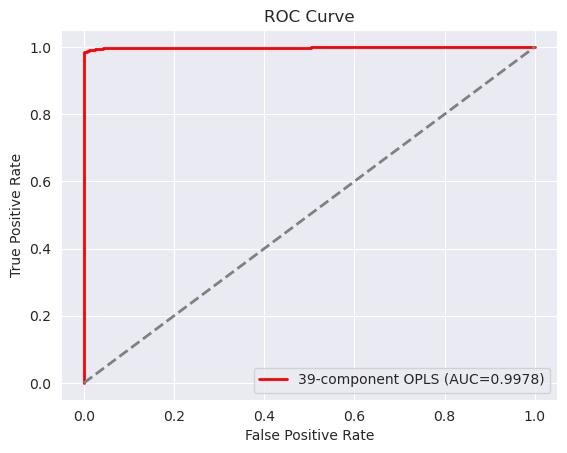

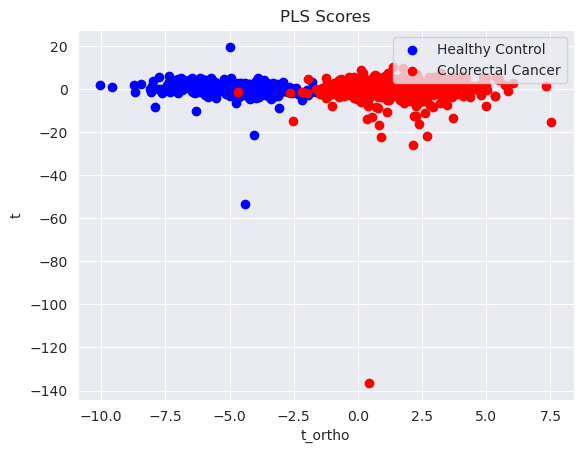

In [14]:

opls = OPLS(20)
Z = opls.fit_transform(spectra, target)

pls = PLSRegression(1)

processed_y_pred = cross_val_predict(pls, Z, target, cv=LeaveOneOut())
processed_q_squared = r2_score(target, processed_y_pred)  # 0.981
processed_dq_squared = r2_score(target, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(target, np.sign(processed_y_pred))  # 1.0

r2_X = opls.score(spectra)  # 7.8e-12 (most variance is removed)

proc_fpr, proc_tpr, proc_thresholds = roc_curve(target, processed_y_pred)
proc_roc_auc = roc_auc_score(target, processed_y_pred)

plt.figure(0)
plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'39-component OPLS (AUC={proc_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(1)
pls.fit(Z, target)
df = pd.DataFrame(np.column_stack([pls.x_scores_, opls.T_ortho_[:, 0]]),
                  index=spectra.index, columns=['t', 't_ortho'])
pos_df = df[target==1]
neg_df = df[target==-1]
plt.scatter(neg_df['t'], neg_df['t_ortho'], c='blue', label='Healthy Control')
plt.scatter(pos_df['t'], pos_df['t_ortho'], c='red', label='Colorectal Cancer')
plt.title('PLS Scores')
plt.xlabel('t_ortho')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()


Confusion matrix 

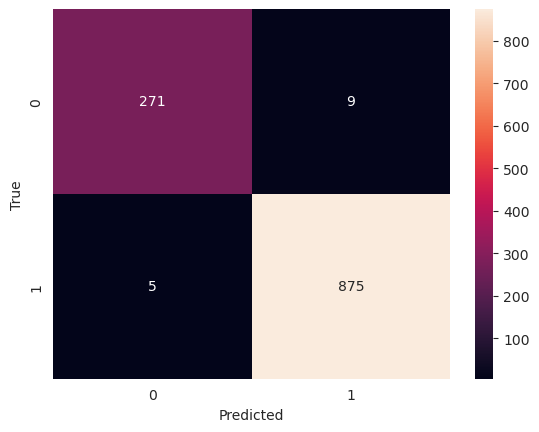

In [15]:
from sklearn.metrics import confusion_matrix

#using seaborn
cm = confusion_matrix(target, np.sign(processed_y_pred))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Precision, Recall, F1-score

In [16]:
from sklearn.metrics import classification_report

print(classification_report(target, np.sign(processed_y_pred)))


              precision    recall  f1-score   support

          -1       0.98      0.97      0.97       280
           1       0.99      0.99      0.99       880

    accuracy                           0.99      1160
   macro avg       0.99      0.98      0.98      1160
weighted avg       0.99      0.99      0.99      1160
